# Project 4: Communicate Data Findings

São Paulo, 30 July of 2019<br>
Felipe Mahlmeister

<a id='summary'></a>
## 1. Summary

#### Intro
The data consists of flight arrival and departure details for all commercial flights within the USA, from October 1987 to April 2008. This is a large dataset: there are nearly 120 million records in total, and takes up 1.6 gigabytes of space compressed and 12 gigabytes when uncompressed.

These files were downloaded at: http://stat-computing.org/dataexpo/2009/the-data.html

#### Objective

1. We're going to explore which is the airport with the highest traffic
2. How much the traffic increased over the years? Let's check it out with a trending line over the years
3. Which are the most used routes? Let's look at the most used routes with routes drawn on a graph of the United States

<a id='data_wrangling'></a>
## 2. Data Wrangling

In [40]:
# import all default packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import sqlite3
conn = sqlite3.connect("source/all_data.db")
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.api.types import union_categoricals
import time
import timeit
import plotly.graph_objects as go

# Import my packages
# Packages to get flights data
from jupyterworkflow.data import get_url
from jupyterworkflow.data import get_download_and_unzip
from jupyterworkflow.data import get_flights_data
from jupyterworkflow.data import get_supplemental_data

# Packages to create SQL tables with csv files
from jupyterworkflow.data import create_raw_table
from jupyterworkflow.data import raw_data_entry
from jupyterworkflow.data import create_supl_tables
from jupyterworkflow.data import supl_tables_data_entry
from jupyterworkflow.data import create_data_table
from jupyterworkflow.data import chunk_preprocessing_numpy

# Packages to get SQL queries to DataFrame
from jupyterworkflow.data import chunk_preprocessing_numpy
from jupyterworkflow.data import df_processing_cat
from jupyterworkflow.data import query_to_df

<a id='extract'></a>
### 2.1. Extracting the Data

In [2]:
# Choose the range of years you want to download
start_year = 1987
last_year = 2008

In order to achieve reproducibility of this project, the below packages download the files from [stat-computing.org](http://stat-computing.org/dataexpo/2009/the-data.html) according to `start_year` and `last_year` automatically, it also unzip these files in source folder.

Package codes in: `jupyterworkflow/data.py`

In [3]:
url, filepath = get_url(start_year, last_year)
get_flights_data(url, filepath)

All the files have already been downloaded


IndexError: list index out of range

We'll also download Supplemental data, in order to complement our main dataset

In [4]:
get_supplemental_data()

<a id='preliminary_wrangling'></a>
### 2.2. Preliminary Wrangling

Before we began to import all csv files to dataframes, first we need to know if it can be imported in a regular workspace.
Let's import the last year file (`2008.csv`) and take a look how much memory it requires:

In [5]:
df = pd.read_csv('source/2008.csv', nrows=5)

In [6]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 29 columns):
Year                 5 non-null int64
Month                5 non-null int64
DayofMonth           5 non-null int64
DayOfWeek            5 non-null int64
DepTime              5 non-null int64
CRSDepTime           5 non-null int64
ArrTime              5 non-null int64
CRSArrTime           5 non-null int64
UniqueCarrier        5 non-null object
FlightNum            5 non-null int64
TailNum              5 non-null object
ActualElapsedTime    5 non-null int64
CRSElapsedTime       5 non-null int64
AirTime              5 non-null int64
ArrDelay             5 non-null int64
DepDelay             5 non-null int64
Origin               5 non-null object
Dest                 5 non-null object
Distance             5 non-null int64
TaxiIn               5 non-null int64
TaxiOut              5 non-null int64
Cancelled            5 non-null int64
CancellationCode     0 non-null float64
Diverted           

<b>Only this dataframe requires 3.0 GB of memory !</b> <i>(if we had loaded the whole csv file)</i><br> 
Considering that we have 22 csv files with almost the same amount of required memory, it's almost impossible to open them on a regular workspace.

To analysis the whole years' range, we need a better approach than just simply import all these files as we did on the last code line.

To avoid overflow our memory trying to handle this large amount of data in pandas, we will utilize sqlite to handle this task and we'll only import to pandas the data we judge necessary.

We'll take the following strategy:

1. Analyze raw data
2. Create raw data table and fill it with data
3. Analyze whether we need all columns and create a table with only the data that we deem necessary

<a id='assess'></a>
### 2.3. Assess

#### 2.3.1. Analyze raw data

#### <div align='center'>Variable descriptions according to [stat-computing.org](http://stat-computing.org/dataexpo/2009/the-data.html)</div>

| &nbsp; | Name | Description |
| ------ | ---- | ----------- |
| 1 | Year | 1987-2008 |
| 2 | Month | 1-12 |
| 3 | DayofMonth | 1-31 |
| 4 | DayOfWeek | 1 (Monday) - 7 (Sunday) |
| 5 | DepTime | actual departure time (local, hhmm) |
| 6 | CRSDepTime | scheduled departure time (local, hhmm) |
| 7 | ArrTime | actual arrival time (local, hhmm) |
| 8 | CRSArrTime | scheduled arrival time (local, hhmm) |
| 9 | UniqueCarrier | unique carrier code |
| 10 | FlightNum | flight number |
| 11 | TailNum | plane tail number |
| 12 | ActualElapsedTime | in minutes |
| 13 | CRSElapsedTime | in minutes |
| 14 | AirTime | in minutes |
| 15 | ArrDelay | arrival delay, in minutes |
| 16 | DepDelay | departure delay, in minutes |
| 17 | Origin | origin IATA airport code |
| 18 | Dest | destination IATA airport code |
| 19 | Distance | in miles |
| 20 | TaxiIn | taxi in time, in minutes |
| 21 | TaxiOut | taxi out time in minutes |
| 22 | Cancelled | was the flight cancelled? |
| 23 | CancellationCode | reason for cancellation (A = carrier, B = weather, C = NAS, D = security) |
| 24 | Diverted | 1 = yes, 0 = no |
| 25 | CarrierDelay | in minutes |
| 26 | WeatherDelay | in minutes |
| 27 | NASDelay | in minutes |
| 28 | SecurityDelay | in minutes |
| 29 | LateAircraftDelay | in minutes |

In [7]:
df.head()

Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  \
0  2008      1           3          4     2003        1955     2211   
1  2008      1           3          4      754         735     1002   
2  2008      1           3          4      628         620      804   
3  2008      1           3          4      926         930     1054   
4  2008      1           3          4     1829        1755     1959   

   CRSArrTime UniqueCarrier  FlightNum  ... TaxiIn  TaxiOut  Cancelled  \
0        2225            WN        335  ...      4        8          0   
1        1000            WN       3231  ...      5       10          0   
2         750            WN        448  ...      3       17          0   
3        1100            WN       1746  ...      3        7          0   
4        1925            WN       3920  ...      3       10          0   

   CancellationCode  Diverted  CarrierDelay WeatherDelay NASDelay  \
0               NaN         0           NaN          NaN      NaN   
1               NaN         0           NaN          NaN      NaN   
2               NaN         0           NaN          NaN      NaN   
3               NaN         0           NaN          NaN      NaN   
4               NaN         0           2.0          0.0      0.0   

   SecurityDelay  LateAircraftDelay  
0            NaN                NaN  
1            NaN                NaN  
2            NaN                NaN  
3            NaN                NaN  
4            0.0               32.0  

[5 rows x 29 columns]

In [8]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 29 columns):
Year                 5 non-null int64
Month                5 non-null int64
DayofMonth           5 non-null int64
DayOfWeek            5 non-null int64
DepTime              5 non-null int64
CRSDepTime           5 non-null int64
ArrTime              5 non-null int64
CRSArrTime           5 non-null int64
UniqueCarrier        5 non-null object
FlightNum            5 non-null int64
TailNum              5 non-null object
ActualElapsedTime    5 non-null int64
CRSElapsedTime       5 non-null int64
AirTime              5 non-null int64
ArrDelay             5 non-null int64
DepDelay             5 non-null int64
Origin               5 non-null object
Dest                 5 non-null object
Distance             5 non-null int64
TaxiIn               5 non-null int64
TaxiOut              5 non-null int64
Cancelled            5 non-null int64
CancellationCode     0 non-null float64
Diverted           

#### 2.3.2. Create raw data table and fill it with data

In [ ]:
# Create raw table
conn = sqlite3.connect("source/all_data.db")
create_raw_table(conn)

# Raw data entry
conn = sqlite3.connect("source/all_data.db")
raw_data_entry(conn,start_year,last_year, chunksize=3000000)

In [ ]:
# Create supplemental data tables
conn = sqlite3.connect("source/all_data.db")
create_supl_tables(conn)

# Supplemental data entry (Airports, Carriers and Plane-data)
conn = sqlite3.connect("source/all_data.db")
supl_tables_data_entry(conn)

#### 2.3.3. Analyze whether we need all columns and create a table with only the data that we deem necessary

In order to focus on the objectives of this analysis, we'll discard any aspect without a relationship with it, so we'll discard delays/elapsed time/etc columns from raw_data table and we'll keep the following:

`Year`, `Month`, `DayofMonth`,`FlightNum`,`Distance`,`UniqueCarrier`,`TailNum`,`Origin`,`Dest`

As we will do some visualizations with timeseries charts, we'll also transform `Year`, `Month`, `DayofMonth` atributes into only one: `Date`

In [ ]:
# Create data table
create_data_table(conn)

### What is the structure of your dataset?

The data consists of flight arrival and departure details for all commercial flights within the USA, from October 1987 to April 2008.

This is a large dataset: there are nearly 120 million records in total, and takes up 12 gigabytes of space when uncompressed.

The dataset contains features about:

- Flights: Date, start/end time, how long the trip took, Origin/Destination, Distance, delay type and delay time, cancellation reason
- Airports: city, state, lat/long
- Carriers: Carriers name
- Planes: Manufacturer, model, status, engine type

### What is/are the main feature(s) of interest in your dataset?

I'm most interested in figuring out:

- Which is the airport with the highest traffic
- How much the traffic increased over the years?
- Which are the most used routes?

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

The flight dates and Origin and Destination will be the main features to support my investigation

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

I'll start by looking at the total number of flights of each Origin and Destination.

In [9]:
query = """SELECT Dest
             FROM data"""

conn = sqlite3.connect("source/all_data.db")
c = conn.cursor()
df = query_to_df(query, conn, chunksize=10000000)

10.0 M rows
20.0 M rows
30.0 M rows
40.0 M rows
50.0 M rows
60.0 M rows
70.0 M rows
80.0 M rows
90.0 M rows
100.0 M rows
110.0 M rows
120.0 M rows
123.534969 M rows
import to DataFrame: 343 seconds
import to DataFrame: 6 minutes


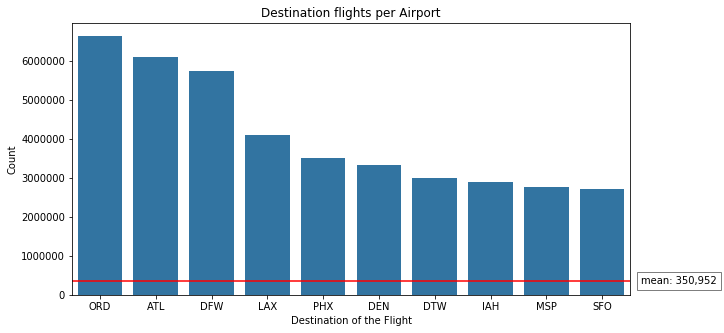

In [11]:
# Setting to the variable no_color
base_color = sns.color_palette()[0]

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 5))

# plt.figure(figsize=(10,5))
top_10 = df.Dest.value_counts()[:10].index
sns.countplot(data = df, x = 'Dest', color = base_color, order=top_10)

# Labels and legend
plt.axhline(df.Dest.value_counts().mean(), color='red');
ax.text(1.02, df.Dest.value_counts().mean(),
        'mean: {:,.0f}'.format(df.Dest.value_counts().mean()), va='center', ha="left", 
        bbox=dict(facecolor="w",alpha=0.5), transform=ax.get_yaxis_transform())
plt.xlabel('Destination of the Flight')
plt.ylabel('Count')

# Plot title
plt.title('Destination flights per Airport')

plt.show()

Observation 1:

We could see that Chicago (ORD) is the Destination of the most of flights in the United States of all the time, followed by Atlanta (ATL) and Dallas (DFW). 

Because of the huge amount of airports in the United States (347) and its spread across the country, the mean of flights in the US is 356K, which is way lower than the top 10 most used airports. Which is an indication that some of these airports are focal points of the US air network.

Let's take a look what's the most common Origin of these flights:

In [17]:
query = """SELECT Origin
             FROM data"""

conn = sqlite3.connect("source/all_data.db")
c = conn.cursor()
df = query_to_df(query, conn, chunksize=10000000)

10.0 M rows
20.0 M rows
30.0 M rows
40.0 M rows
50.0 M rows
60.0 M rows
70.0 M rows
80.0 M rows
90.0 M rows
100.0 M rows
110.0 M rows
120.0 M rows
123.534969 M rows
import to DataFrame: 392 seconds
import to DataFrame: 7 minutes


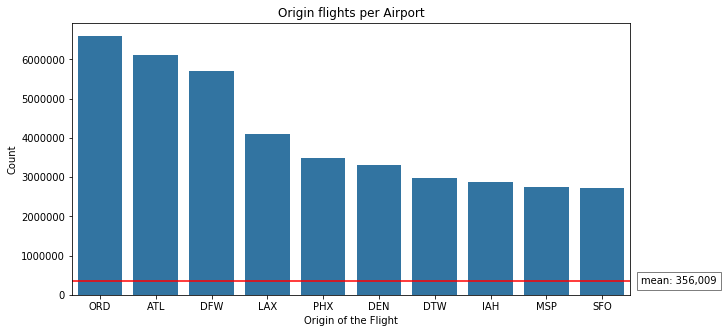

In [19]:
# Setting to the variable no_color
base_color = sns.color_palette()[0]

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 5))

top_10 = df.Origin.value_counts()[:10].index
sns.countplot(data = df, x = 'Origin', color = base_color, order=top_10)

# Plot title
plt.title('Origin flights per Airport')

# Labels and legend
plt.axhline(df.Origin.value_counts().mean(), color='red');
ax.text(1.02, df.Origin.value_counts().mean(),
        'mean: {:,.0f}'.format(df.Origin.value_counts().mean()), va='center', ha="left", 
        bbox=dict(facecolor="w",alpha=0.5), transform=ax.get_yaxis_transform())
plt.xlabel('Origin of the Flight')
plt.ylabel('Count')

plt.show()

Observation 2:

As expected, the Origin and Destination is almost the same. From now on we will consider the origin and destination as a single value.

In [20]:
df.Origin.nunique()

347

In [21]:
df.Origin.value_counts().sum()

123534969

In [22]:
df.Origin.value_counts().mean()/df.Origin.value_counts().sum()

0.0028818443804034585

In [23]:
df.Origin.value_counts()[:10]

ORD    6597442
ATL    6100953
DFW    5710980
LAX    4089012
PHX    3491077
DEN    3319905
DTW    2979158
IAH    2884518
MSP    2754997
SFO    2733910
Name: Origin, dtype: int64

In [24]:
(df.Origin.value_counts()[:10]/df.Origin.value_counts().sum())*100

ORD    5.340546
ATL    4.938645
DFW    4.622966
LAX    3.310004
PHX    2.825983
DEN    2.687421
DTW    2.411591
IAH    2.334981
MSP    2.230135
SFO    2.213066
Name: Origin, dtype: float64

In [25]:
sum((df.Origin.value_counts()[:3]/df.Origin.value_counts().sum())*100)

14.902156975487646

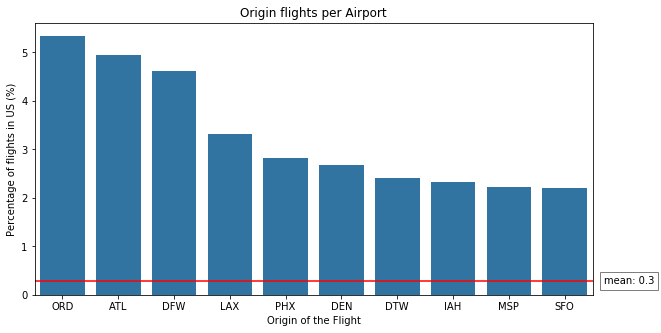

In [26]:
# Setting to the variable no_color
base_color = sns.color_palette()[0]

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 5))

x = df.Origin.value_counts()[:10].index
y = (df.Origin.value_counts()[:10]/df.Origin.value_counts().sum())*100
z = pd.DataFrame(y)

top_10 = df.Origin.value_counts()[:10].index
g = sns.barplot(x = x, y = y, color = base_color, order = top_10)

# Plot title
plt.title('Origin flights per Airport')

# Labels and legend
plt.axhline(df.Origin.value_counts().mean()/df.Origin.value_counts().sum()*100, color='red');
ax.text(1.02, df.Origin.value_counts().mean()/df.Origin.value_counts().sum()*100,
        'mean: {:,.1f}'.format(df.Origin.value_counts().mean()/df.Origin.value_counts().sum()*100), 
        va='center', ha="left", 
        bbox=dict(facecolor="w",alpha=0.5), transform=ax.get_yaxis_transform())
plt.xlabel('Origin of the Flight')
plt.ylabel('Percentage of flights in US (%)')

plt.show()

Observation 3:

Looking for the amount of flights in percentage point of view, the airports of Chicago (ORD), Atlanta (ATL) and Dallas (DFW) represents 15% of all flights in US themselves, which is huge !

At this moment, we are looking for the top 10, but what about the bottom 20? Let's take a look:


In [27]:
df.Origin.value_counts()[-20:]

SOP    319
INL    290
MKK    289
LNY    289
BJI    202
MAZ    149
MTH    128
MIB     89
FOE     57
RDR     46
PIR     10
CKB      8
OGD      6
FMN      3
PVU      2
GLH      2
CYS      2
MKC      1
BFF      1
BFI      1
Name: Origin, dtype: int64

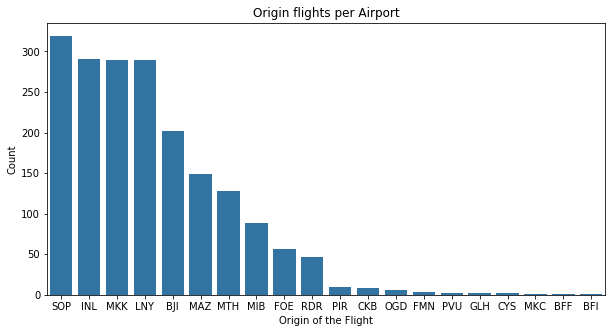

In [28]:
# Setting to the variable no_color
base_color = sns.color_palette()[0]

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 5))

bottom_10 = df.Origin.value_counts()[-20:].index
sns.countplot(data = df, x = 'Origin', color = base_color, order=bottom_10)

# Plot title
plt.title('Origin flights per Airport')

# Labels and legend
plt.xlabel('Origin of the Flight')
plt.ylabel('Count')

plt.show()

Observation 4:

Now looking for the bottom 20, something interesting happens: some airports has 1, 2, 3 flights over all the time. Why it happens?

Searching on the internet, we can see the following:

1. Boeing Field/King County Intl (BFI) is a public airport and its is mostly used by general aviation and cargo. [source](https://en.wikipedia.org/wiki/Boeing_Field)<br><br>

2. Scotts Bluff County airport (BFF) has one passenger airline, subsidized by the Essential Air Service program, with 4,262 passenger boardings in 2016. The National Plan of Integrated Airport Systems for 2017–2021 categorized it as a non-primary commercial service airport. [source](https://en.wikipedia.org/wiki/Western_Nebraska_Regional_Airport)<br><br>

3. Charles B. Wheeler Downtown Airport of Kansas City (MKC) had limited area for expansion. Airplanes had to avoid the 200-foot Quality Hill and the Downtown Kansas City skyline south of the south end of the main runway. In the early 1960s an FAA memo called it "the most dangerous major airport in the country" and urged that no further federal funds be spent on it. Kansas City replaced the airport in 1972 with Kansas City International Airport. [source](https://en.wikipedia.org/wiki/Charles_B._Wheeler_Downtown_Airport)

Now that we already know what's the top 5 busiest airports in the US, why we don't take a look at the major companies that operate on these airports?

In [31]:
query = """SELECT Id,
                  Date,
                  UniqueCarrier,
                  Description,
                  Origin
             FROM data
        LEFT JOIN carriers ON carriers.Code = data.UniqueCarrier
            WHERE Origin = 'ORD' OR
                  Origin  = 'ATL' OR
                  Origin = 'DFW' OR
                  Origin = 'LAX' OR
                  Origin = 'PHX'"""

conn = sqlite3.connect("source/all_data.db")
c = conn.cursor()
df = query_to_df(query, conn, chunksize=4000000)

4.0 M rows
8.0 M rows
12.0 M rows
16.0 M rows
20.0 M rows
24.0 M rows
25.989464 M rows
import to DataFrame: 470 seconds
import to DataFrame: 8 minutes


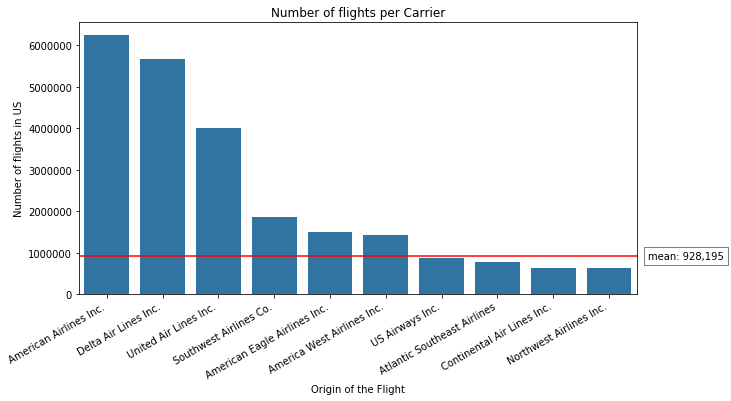

In [32]:
# Setting to the variable no_color
base_color = sns.color_palette()[0]

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 5))

x = df.Description.value_counts()[:10].index
y = df.Description.value_counts()[:10].values
z = pd.DataFrame(y)

top_10 = df.Description.value_counts()[:10].index
g = sns.barplot(x = x, y = y, color = base_color, order = top_10)

# Plot title
plt.title('Number of flights per Carrier')

# Labels and legend
plt.axhline(df.Description.value_counts().mean(), color='red');
ax.text(1.02, df.Description.value_counts().mean(),
        'mean: {:,.0f}'.format(df.Description.value_counts().mean()), 
        va='center', ha="left", 
        bbox=dict(facecolor="w",alpha=0.5), transform=ax.get_yaxis_transform())
plt.xlabel('Origin of the Flight')
plt.xticks(rotation=30, ha='right')
plt.ylabel('Number of flights in US')

plt.show()

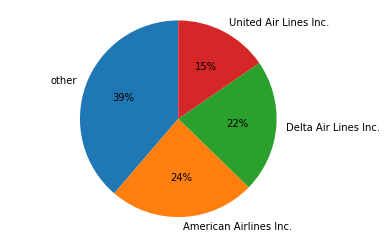

In [33]:
# Preprocessing DataFrame to filter only the top 3 most visited airports 
# and label the remaining as 'other'
top_3 = ['American Airlines Inc.','Delta Air Lines Inc.','United Air Lines Inc.']
df['Description_2'] = np.where(df['Description'].isin(top_3),df['Description'],'other')
df.loc[:,'Description_2'] = df.loc[:,'Description_2'].astype('category')

labels = df.Description_2.value_counts().index
sizes = df.Description_2.value_counts().values

fig1, ax1 = plt.subplots()

ax1.pie(sizes, labels=labels, autopct='%1.0f%%',shadow=False, startangle=90)

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Observation 5:

The US has clearly 3 majors companies that dominate their commercial aircraft market:

- American Airlines Inc.
- Delta Air Lines Inc.
- United Air Lines Inc.

More than 60% of the flights in the US are from one of these companies.

On the next topics, we'll investigate further from where this flow comes.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

Thankfully, due to thorough cleaning efforts there were no big surprises during the exploratory and visualization phase. But we had some interesting thoughts by looking at the bottom 20 airports, we can put together a train of thought based on the evidence collected on the internet:

1. Most of the airports of bottom 20 is motly used by general aviation and cargo, and its flights wasn't accounted by our data, which focus on domestic flights.

2. Some of these airports have already changed its names over the years.

3. Because of their irrelevance, some flights from certain airports may not have been accounted for.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

We have 10 airports with 10 flights or less over 21 years, this sounds strange, but I made some assumptions that can explain these numbers.

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

In this section, we will investigate how much the traffic increased over the years and its behavior during the years.

To be pratical, we will focus only on the top 5 airports:

1. Chicago O'Hare International (ORD)
- William B Hartsfield-Atlanta Intl (ATL)
- Dallas-Fort Worth International (DFW)
- Los Angeles International (LAX)
- Phoenix Sky Harbor International (PHX)

To start our time series analysis, we can see that if we plot all the data we have, the graph will be noisier (as the following plot). To avoid this effect, we'll utilize the Moving Average technique, which we'll consider only the mean of occurrences in order to smooth the graph and easily shows the trends.
Let's try some means and see which one fits better.

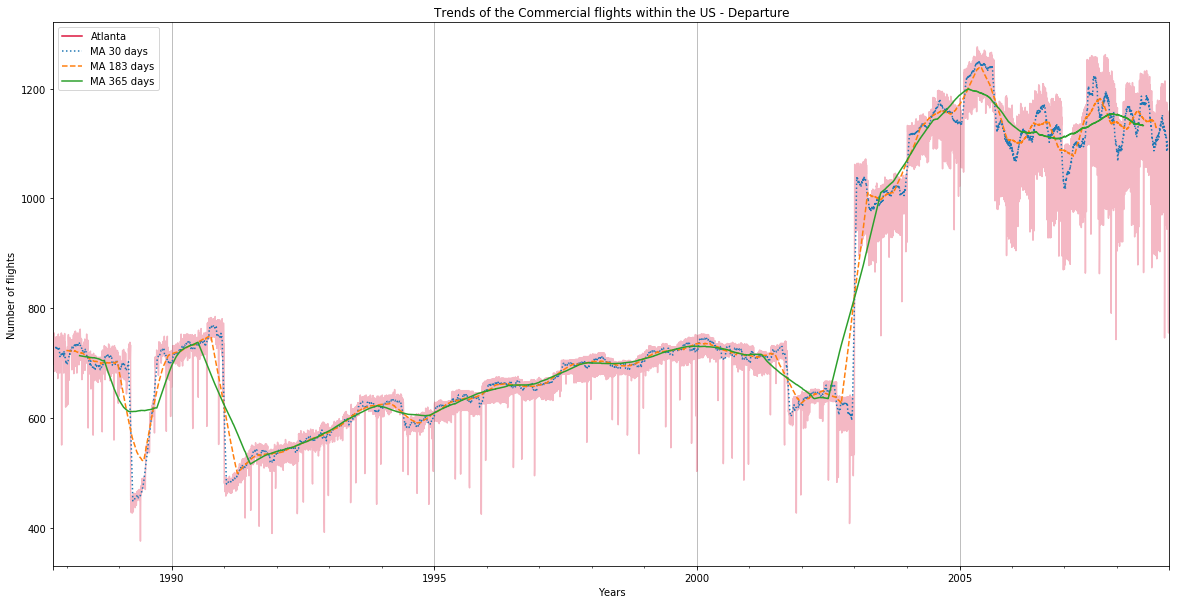

In [34]:
# Variables
data = df.groupby(by=['Origin','Date']).count()['Id']['ATL']

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

data.plot(label='Atlanta', color = 'crimson')
data.rolling(30, center=True).mean().plot(label='MA 30 days', style=':')
data.rolling(183, center=True).mean().plot(label='MA 183 days', style='--')
data.rolling(365, center=True).mean().plot(label='MA 365 days', style='-')

# Labels and legend
plt.xlabel('Years')
plt.ylabel('Number of flights')
plt.legend(loc='upper left')
ax.grid(axis='x')
ax.lines[0].set_alpha(0.3)

# Plot title
plt.title('Trends of the Commercial flights within the US - Departure')
plt.show()

The chosen option was a moving average with 365 days because it has a smooth path even without losing information about the raw data.

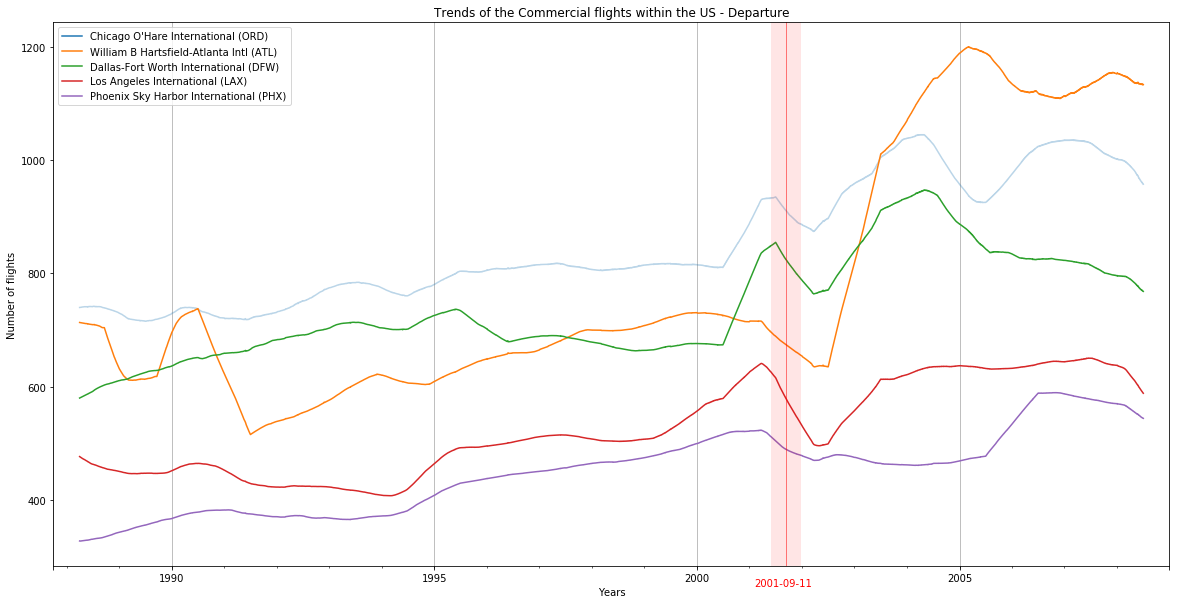

In [35]:
# Variables
data_ORD = df.groupby(by=['Origin','Date']).count()['Id']['ORD']
data_ATL = df.groupby(by=['Origin','Date']).count()['Id']['ATL']
data_DFW = df.groupby(by=['Origin','Date']).count()['Id']['DFW']
data_LAX = df.groupby(by=['Origin','Date']).count()['Id']['LAX']
data_PHX = df.groupby(by=['Origin','Date']).count()['Id']['PHX']

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

data_ORD.rolling(365, center=True).mean().plot(label="Chicago O'Hare International (ORD)", style='-')
data_ATL.rolling(365, center=True).mean().plot(label="William B Hartsfield-Atlanta Intl (ATL)", style='-')
data_DFW.rolling(365, center=True).mean().plot(label="Dallas-Fort Worth International (DFW)", style='-')
data_LAX.rolling(365, center=True).mean().plot(label="Los Angeles International (LAX)", style='-')
data_PHX.rolling(365, center=True).mean().plot(label="Phoenix Sky Harbor International (PHX)", style='-')

# Labels and legend
plt.xlabel('Years')
plt.ylabel('Number of flights')
plt.legend(loc='upper left')
ax.grid(axis='x')
ax.lines[0].set_alpha(0.3)

ax.axvline('2001-09-11', linewidth=30, alpha=0.1, color='red')
ax.axvline('2001-09-11', linewidth=1, alpha=0.5, color='red')
ax.text(x='2001-02-01', y=250, s='2001-09-11', alpha=1, color='red')

# Plot title
plt.title('Trends of the Commercial flights within the US - Departure')
plt.show()

The above graph show us some interesting things:

1. <i>"After years of labor disputes, high operating costs, financial losses and crippling debt, Eastern Airlines ceased operations on January 18, 1991 and the assets were liquidated. Once the largest airline in the free world, Eastern had been pivotal in the development of Atlanta as a major air hub..." [source](https://www.sunshineskies.com/atlanta-airport-1990s.html)</i><br><br>This event can be observed as a big trend drop at the start of the '90s, represented as the yellow trace on the above graph. This airport only came near to the same level of activity 10 years after.<br><br>

2. <i>"In May 2001 construction of an over 9,000-foot (2,700 m) fifth runway (10–28) began. It was completed at a cost of 1.28 billion and opened on May 27, 2006 ... The fifth runway is expected to increase the capacity for landings and take-offs by 40%, from an average of 184 flights per hour to 237 flights per hour..." [source](https://en.wikipedia.org/wiki/Hartsfield%E2%80%93Jackson_Atlanta_International_Airport)</i> <br><br>This event can be observed as a big trend that started on 2002 and ends on 2005, making this airport to become the busiest airport in the world ! [source](https://en.wikipedia.org/wiki/Hartsfield%E2%80%93Jackson_Atlanta_International_Airport)<br><br>

3. You can clearly see a sharp drop in the number of flights at all airports shortly after the September 11, 2001 incident. It took an average of 1 year for these airports to return to their previous level of activity.

After investigating the growth trendings over the years of the top 5 busiest airports in the US, why we don't also take a look at how the Carriers behaved during the years?

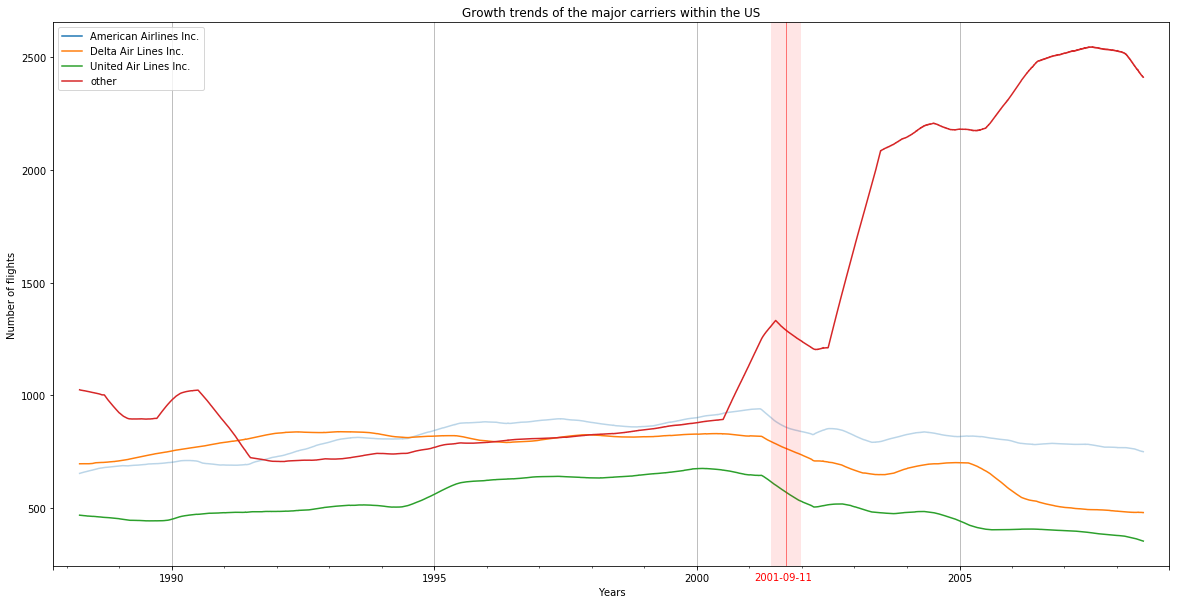

In [36]:
# Variables
data_AA = df.groupby(by=['Description_2','Date']).count()['Id']['American Airlines Inc.']
data_DL = df.groupby(by=['Description_2','Date']).count()['Id']['Delta Air Lines Inc.']
data_UA = df.groupby(by=['Description_2','Date']).count()['Id']['United Air Lines Inc.']
data_other = df.groupby(by=['Description_2','Date']).count()['Id']['other']

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

data_AA.rolling(365, center=True).mean().plot(label='American Airlines Inc.', style='-')
data_DL.rolling(365, center=True).mean().plot(label='Delta Air Lines Inc.', style='-')
data_UA.rolling(365, center=True).mean().plot(label='United Air Lines Inc.', style='-')
data_other.rolling(365, center=True).mean().plot(label='other', style='-')

# Labels and legend
plt.xlabel('Years')
plt.ylabel('Number of flights')
plt.legend(loc='upper left')
ax.grid(axis='x')
ax.lines[0].set_alpha(0.3)

ax.axvline('2001-09-11', linewidth=30, alpha=0.1, color='red')
ax.axvline('2001-09-11', linewidth=1, alpha=0.5, color='red')
ax.text(x='2001-02-01', y=180, s='2001-09-11', alpha=1, color='red')

# Plot title
plt.title('Growth trends of the major carriers within the US')
plt.show()

1. The sharp uptrend that starts at the beginning of the '2000s is a consequence of the opening of the market to low-cost airlines. [source](http://aviationknowledge.wikidot.com/aviation:low-cost-airlines:a-brief-history-the-current-state)

2. The low-cost companies felt more of the 9/11 event, while larger companies had a less steep drop.

3. The top 3 major aircraft companies are on a downtrend from 11/09 until nowadays, probably this downtrend has little influence with this event and big relationship with its operational cost, which tends to be huge on the majors and lower year after year by the low-cost airlines.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> The addition of the low-cost companies on the market made a significant change on the market, this is probably primarily responsible by the downtrend of the major companies. <br>Big incidents, as the 11/09 can cause a big impact on the market, the airports took an average of 1 year to return to their previous level of activity. <br> Strategic reforms / extensions / modernization could be the key to grow the activity on the airports and consequently bring more revenue.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Political actions can have a major impact on this market, as market opening for low-cost companies has completely changed this market.

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

We already investigate what's the busiest airports in the US and the biggest carriers that operate on it. 

Why we don't investigate further the relationship between both of them? 

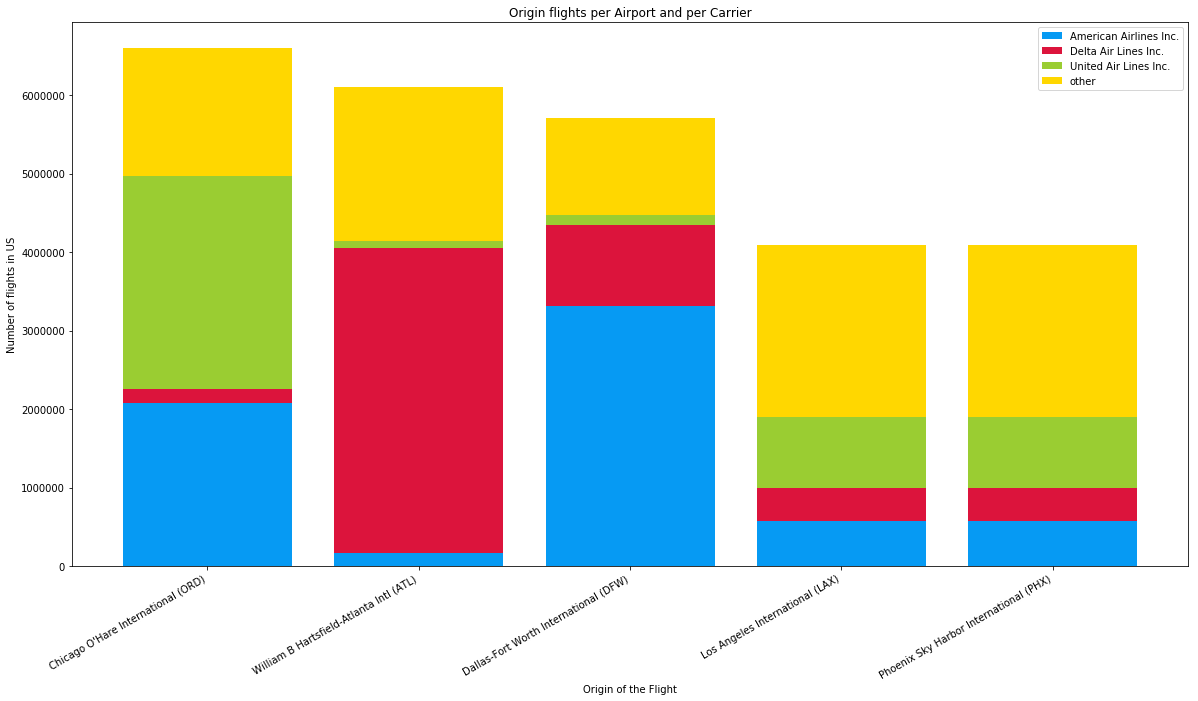

In [37]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

airports = ["Chicago O'Hare International (ORD)",
            "William B Hartsfield-Atlanta Intl (ATL)",
            "Dallas-Fort Worth International (DFW)",
            "Los Angeles International (LAX)",
            "Phoenix Sky Harbor International (PHX)"]

indx = np.arange(len(airports))

AA_color = 'xkcd:azure'
DL_color = 'crimson'
UA_color = 'yellowgreen'
other_color = 'gold'

# x_airports = pd.Series(airports)

# Chicago
y_1_1 = df.groupby(by=['Origin','Description_2']).count()['Id']['ORD'].values[0]
plt.bar(x=[0], height=y_1_1, color=AA_color)

y_1_2 = df.groupby(by=['Origin','Description_2']).count()['Id']['ORD'].values[1]
plt.bar(x=[0], height=y_1_2, bottom = y_1_1,color=DL_color)

y_1_3 = df.groupby(by=['Origin','Description_2']).count()['Id']['ORD'].values[2]
plt.bar(x=[0], height=y_1_3, bottom = y_1_1+y_1_2, color=UA_color)

y_1_4 = df.groupby(by=['Origin','Description_2']).count()['Id']['ORD'].values[3]
plt.bar(x=[0], height=y_1_4, bottom = y_1_1+y_1_2+y_1_3,color=other_color)

# Atlanta
y_2_1 = df.groupby(by=['Origin','Description_2']).count()['Id']['ATL'].values[0]
plt.bar(x=[1], height=y_2_1, color=AA_color)

y_2_2 = df.groupby(by=['Origin','Description_2']).count()['Id']['ATL'].values[1]
plt.bar(x=[1], height=y_2_2, bottom = y_2_1,color=DL_color)

y_2_3 = df.groupby(by=['Origin','Description_2']).count()['Id']['ATL'].values[2]
plt.bar(x=[1], height=y_2_3, bottom = y_2_1+y_2_2, color=UA_color)

y_2_4 = df.groupby(by=['Origin','Description_2']).count()['Id']['ATL'].values[3]
plt.bar(x=[1], height=y_2_4, bottom = y_2_1+y_2_2+y_2_3,color=other_color)

# Dallas
y_3_1 = df.groupby(by=['Origin','Description_2']).count()['Id']['DFW'].values[0]
plt.bar(x=[2], height=y_3_1, color=AA_color)

y_3_2 = df.groupby(by=['Origin','Description_2']).count()['Id']['DFW'].values[1]
plt.bar(x=[2], height=y_3_2, bottom = y_3_1,color=DL_color)

y_3_3 = df.groupby(by=['Origin','Description_2']).count()['Id']['DFW'].values[2]
plt.bar(x=[2], height=y_3_3, bottom = y_3_1+y_3_2, color=UA_color)

y_3_4 = df.groupby(by=['Origin','Description_2']).count()['Id']['DFW'].values[3]
plt.bar(x=[2], height=y_3_4, bottom = y_3_1+y_3_2+y_3_3,color=other_color)

# Los Angeles
y_4_1 = df.groupby(by=['Origin','Description_2']).count()['Id']['LAX'].values[0]
plt.bar(x=[3], height=y_4_1, color=AA_color)

y_4_2 = df.groupby(by=['Origin','Description_2']).count()['Id']['LAX'].values[1]
plt.bar(x=[3], height=y_4_2, bottom = y_4_1,color=DL_color)

y_4_3 = df.groupby(by=['Origin','Description_2']).count()['Id']['LAX'].values[2]
plt.bar(x=[3], height=y_4_3, bottom = y_4_1+y_4_2, color=UA_color)

y_4_4 = df.groupby(by=['Origin','Description_2']).count()['Id']['LAX'].values[3]
plt.bar(x=[3], height=y_4_4, bottom = y_4_1+y_4_2+y_4_3,color=other_color)

# Phoenix
y_5_1 = df.groupby(by=['Origin','Description_2']).count()['Id']['LAX'].values[0]
plt.bar(x=[4], height=y_5_1, color=AA_color)

y_5_2 = df.groupby(by=['Origin','Description_2']).count()['Id']['LAX'].values[1]
plt.bar(x=[4], height=y_5_2, bottom = y_5_1,color=DL_color)

y_5_3 = df.groupby(by=['Origin','Description_2']).count()['Id']['LAX'].values[2]
plt.bar(x=[4], height=y_5_3, bottom = y_5_1+y_5_2, color=UA_color)

y_5_4 = df.groupby(by=['Origin','Description_2']).count()['Id']['LAX'].values[3]
plt.bar(x=[4], height=y_5_4, bottom = y_5_1+y_5_2+y_5_3,color=other_color)

# Plot title
plt.title('Origin flights per Airport and per Carrier')

# Labels and legend
plt.xlabel('Origin of the Flight')
plt.xticks(indx,airports,rotation=30, ha='right')
plt.ylabel('Number of flights in US')
# sns.despine(left=True)

leg_AA = plt.Rectangle((0,0),1,1,fc=AA_color, edgecolor = 'none')
leg_DL = plt.Rectangle((0,0),1,1,fc=DL_color,  edgecolor = 'none')
leg_UA = plt.Rectangle((0,0),1,1,fc=UA_color,  edgecolor = 'none')
leg_other = plt.Rectangle((0,0),1,1,fc=other_color,  edgecolor = 'none')
plt.legend([leg_AA, leg_DL,leg_UA,leg_other], ['American Airlines Inc.',
                                               'Delta Air Lines Inc.',
                                               'United Air Lines Inc.',
                                               'other'], loc=1, ncol = 1)
plt.show()

1. As expected, we clearly see that the top 3 biggest carriers have dominance on the biggest airports of the US, but surprisingly, this dominance doesn't occur on the Los Angeles and Phoenix airports, where the low-cost carriers operate the most of flights.<br><br>

2. Each of the top 3 biggest airports in US have a agreement with each major carrier:
    - Dallas: American Airlines
    - Atlanta: Delta Airlines
    - Chicago: United Airlines and American Airlines

In [41]:
query = """SELECT Date,
                  Origin,
                  Dest,
                  airport1.airport AS airport1,
                  airport2.airport AS airport2,
                  airport1.lat AS start_lat,
                  airport1.long AS start_long,
                  airport2.lat AS end_lat,
                  airport2.long AS end_long,
                  Distance
             FROM data
        LEFT JOIN airports AS airport1 ON airport1.iata = data.Origin
        LEFT JOIN airports AS airport2 ON airport2.iata = data.Dest
            WHERE Date >= date('2008-01-01')"""

conn = sqlite3.connect("source/all_data.db")
c = conn.cursor()
df = query_to_df(query, conn, chunksize=3000000)

3.0 M rows
6.0 M rows
7.009728 M rows
import to DataFrame: 328 seconds
import to DataFrame: 5 minutes


In [42]:
query = """SELECT iata,
                  airport,
                  city,
                  state,
                  country,
                  lat,
                  long
             FROM airports"""

conn = sqlite3.connect("source/all_data.db")
c = conn.cursor()
df_airports = query_to_df(query, conn, chunksize=5000000)

0.003376 M rows
import to DataFrame: 0 seconds
import to DataFrame: 0 minutes


In [43]:
df_groupby = df.groupby(by=['Origin','Dest']).count()

origin_list = df_groupby.dropna().index.get_level_values(0).tolist()
dest_list = df_groupby.dropna().index.get_level_values(1).tolist()
origin_data = []
dest_data = []

for airport in range(len(origin_list)):
    origin_data.append(origin_list[airport])
    dest_data.append(dest_list[airport])

df_flights = pd.DataFrame(origin_data, columns=['Origin'])
dest_data = pd.Series(dest_data)
df_flights = pd.concat([df_flights,dest_data], axis=1)
df_flights.rename(columns={0:'Dest'}, inplace=True)

airport1_list, airport2_list = [], []
start_lat_list, start_long_list = [], []
end_lat_list, end_long_list = [], []
distance_list = []

for name, group in df.groupby(by=['Origin','Dest']):
    airport1_list.append(group['airport1'].unique().tolist()[0])
    airport2_list.append(group['airport2'].unique().tolist()[0])
    start_lat_list.append(group['start_lat'].unique().tolist()[0])
    start_long_list.append(group['start_long'].unique().tolist()[0])
    end_lat_list.append(group['end_lat'].unique().tolist()[0])
    end_long_list.append(group['end_long'].unique().tolist()[0])
    distance_list.append(group['Distance'].unique().tolist()[0])

airport1_list = pd.Series(airport1_list, name='airport1')
airport2_list = pd.Series(airport2_list, name='airport2')
start_lat_list = pd.Series(start_lat_list, name='start_lat')
start_long_list = pd.Series(start_long_list, name='start_long')
end_lat_list = pd.Series(end_lat_list, name='end_lat')
end_long_list = pd.Series(end_long_list, name='end_long')
distance_list = pd.Series(distance_list, name='Distance')
    
df_flights = pd.concat([df_flights, 
                        airport1_list, 
                        airport2_list,
                        start_lat_list,
                        start_long_list,
                        end_lat_list,
                        end_long_list,
                        distance_list], axis=1)

airports = ["ORD",
            "ATL",
            "DFW",
            "LAX",
            "PHX"]

ord_airport = df_airports[df_airports['iata'].isin([airports[0]])]
atl_airport = df_airports[df_airports['iata'].isin([airports[1]])]
dfw_airport = df_airports[df_airports['iata'].isin([airports[2]])]
lax_airport = df_airports[df_airports['iata'].isin([airports[3]])]
phx_airport = df_airports[df_airports['iata'].isin([airports[4]])]

In [45]:
fig = go.Figure()

fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = df_airports['long'],
    lat = df_airports['lat'],
    hoverinfo = 'text',
    text = df_airports['airport'],
    mode = 'markers',
    name = 'Other',
    marker = dict(
        size = 1,
        color = 'rgb(255, 0, 0)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

flight_paths = []
for i in range(len(df_flights)):
    fig.add_trace(
        go.Scattergeo(
            locationmode = 'USA-states',
            lon = [df_flights['start_long'][i], df_flights['end_long'][i]],
            lat = [df_flights['start_lat'][i], df_flights['end_lat'][i]],
            mode = 'lines',
            showlegend=False,
            line = dict(width = 0.1,color = 'red'),
            opacity = float(df_flights['Distance'][i]) / float(df_flights['Distance'].max()),
        )
    )

# Chicago
fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = ord_airport['long'],
    lat = ord_airport['lat'],
    hoverinfo = 'text',
    text = ord_airport['airport'],
    mode = 'markers',
    name = 'Chicago',
    marker = dict(
        size = 10,
        color = 'crimson',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

# Atlanta
fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = atl_airport['long'],
    lat = atl_airport['lat'],
    hoverinfo = 'text',
    text = ord_airport['airport'],
    mode = 'markers',
    name = 'Atlanta',
    marker = dict(
        size = 10,
        color = 'darkblue',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

# Dallas
fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = dfw_airport['long'],
    lat = dfw_airport['lat'],
    hoverinfo = 'text',
    text = ord_airport['airport'],
    mode = 'markers',
    name = 'Dallas',
    marker = dict(
        size = 10,
        color = 'magenta',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

# Los Angeles
fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = lax_airport['long'],
    lat = lax_airport['lat'],
    hoverinfo = 'text',
    text = ord_airport['airport'],
    mode = 'markers',
    name = 'Los Angeles',
    marker = dict(
        size = 10,
        color = 'yellowgreen',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

# Phoenix
fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = phx_airport['long'],
    lat = phx_airport['lat'],
    hoverinfo = 'text',
    text = ord_airport['airport'],
    mode = 'markers',
    name = 'Phoenix',
    marker = dict(
        size = 10,
        color = 'gold',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

fig.layout.update(
    title_text = '2008 US flight paths<br>(Hover for airport names)',
    showlegend = True,
    geo = go.layout.Geo(
        scope = 'usa',
        projection_type = 'albers usa',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
)

fig.show()

<img src="https://drive.google.com/uc?id=1-xd8O_jSJGZ5lRWOMO2Ki7otKKnFn-6X">

1. The American air network is well distributed throughout its territory.


2. It is more visible a tendency to move horizontally than vertically, as a result of being a flat country and having important business and technological poles at opposite horizontal ends.


3. The five largest airports in the United States are located (not coincidentally) in strategic locations and are the focal points of most flights.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> The American air network is mature thanks to the strategic decisions made over the years, which made possible the development of this market so important for its economy, besides having a geographical advantage of having a wide country and with technological and financial poles in all its extension.<br><br>
The major carriers have dominance on the biggest airports in the US (probably by contract), this could be holding the developing of new business in this field.

### Were there any interesting or surprising interactions between features?

> Surprisingly, the dominance of the major carriers doesn't occur on the Los Angeles and Phoenix airports, where the low-cost carriers operate the most of flights.<br><br>
None of the top 5 biggest airports is on the US east cost. 